In [1]:
import pickle
import json

# Opción 1: Cargar desde pickle
with open('selected_features.pkl', 'rb') as f:
    selected_features = pickle.load(f)
    
# O Opción 2: Cargar desde JSON
# with open('selected_features.json', 'r') as f:
#     selected_features = json.load(f)

# Extraer las listas de features
features_class = selected_features['features_class']
features_reg = selected_features['features_reg']

print("Features para clasificación:")
print(features_class)
print("\nFeatures para regresión:")
print(features_reg)


# Cargar el DataFrame desde el archivo pickle
with open('data_final_rf.pkl', 'rb') as f:
    data_final_rf = pickle.load(f)

print(f"DataFrame cargado correctamente. Dimensiones: {data_final_rf.shape}")

Features para clasificación:
['intraday_volatility', 'volatility_5d', 'volatility_20d', 'range_ratio', 'Change %', 'volatility_50d', 'acc_dist', 'volume_norm_20d', 'Vol.', 'volatility_deviation']

Features para regresión:
['Change %', 'volatility_5d', 'volatility_20d', 'intraday_volatility', 'Vol.', 'Low', 'obv', 'price_vol_corr', 'acc_dist', 'volume_norm_20d']
DataFrame cargado correctamente. Dimensiones: (2022, 53)


In [2]:
def preparar_datos_modelado(df, features_class, features_reg, target_class='significant_move', 
                            target_reg='future_return', train_size=0.7, val_size=0.15):
       
    # Preparar variables X (predictores) y Y (objetivo)
    X_class = df[features_class]
    X_reg = df[features_reg]
    
    y_class = df[target_class]
    y_reg = df[target_reg]
    
    # Calcular índices para división temporal
    n_samples = len(df)
    train_idx = int(train_size * n_samples)
    val_idx = train_idx + int(val_size * n_samples)
    
    # División para clasificación
    X_train_class = X_class[:train_idx]
    y_train_class = y_class[:train_idx]
    X_val_class = X_class[train_idx:val_idx]
    y_val_class = y_class[train_idx:val_idx]
    X_test_class = X_class[val_idx:]
    y_test_class = y_class[val_idx:]
    
    # División para regresión
    X_train_reg = X_reg[:train_idx]
    y_train_reg = y_reg[:train_idx]
    X_val_reg = X_reg[train_idx:val_idx]
    y_val_reg = y_reg[train_idx:val_idx]
    X_test_reg = X_reg[val_idx:]
    y_test_reg = y_reg[val_idx:]
    
        
    # Devolver todo en un diccionario
    return {
        # Conjuntos para clasificación
        'X_train_class': X_train_class,
        'y_train_class': y_train_class,
        'X_val_class': X_val_class,
        'y_val_class': y_val_class,
        'X_test_class': X_test_class,
        'y_test_class': y_test_class,
        
       
        # Conjuntos para regresión
        'X_train_reg': X_train_reg,
        'y_train_reg': y_train_reg,
        'X_val_reg': X_val_reg,
        'y_val_reg': y_val_reg,
        'X_test_reg': X_test_reg,
        'y_test_reg': y_test_reg,
        
        }

In [3]:
data_preparada = preparar_datos_modelado(df= data_final_rf, features_class= features_class, features_reg= features_reg)
data_preparada

{'X_train_class':             intraday_volatility  volatility_5d  volatility_20d  range_ratio  \
 Date                                                                          
 2017-03-20             0.018248       1.480426        0.683953     0.244746   
 2017-03-19             0.028615       0.004888        0.696669     0.410816   
 2017-03-18             0.056470       0.004834        0.707914     0.853792   
 2017-03-17             0.050196       0.213142        0.708041     0.805534   
 2017-03-16             0.043932       0.260199        0.708147     0.755168   
 ...                         ...            ...             ...          ...   
 2013-04-09             0.285867      15.801456       16.284661     0.953613   
 2013-04-08             0.199014      23.296364       16.878077     0.650099   
 2013-04-07             0.156381      26.081458       17.195608     0.508283   
 2013-04-06             0.030921      27.845292       17.464718     0.102766   
 2013-04-05            

### MODELO DE CLASIFICACION

In [5]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, average_precision_score

# Extraer los datos de clasificación que necesitamos
X_train_class = data_preparada['X_train_class']  # Ya están escalados
y_train_class = data_preparada['y_train_class']
X_val_class = data_preparada['X_val_class']      # Ya están escalados
y_val_class = data_preparada['y_val_class']

# Entrenar diferentes modelos
models_class = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(probability=True, random_state=42)
}

results_class = {}

for name, model in models_class.items():
    # Entrenar modelo
    model.fit(X_train_class, y_train_class)
    
    # Predecir en conjunto de validación
    y_pred = model.predict(X_val_class)
    y_prob = model.predict_proba(X_val_class)[:, 1]
    
    # Evaluar rendimiento (enfocado en recall)
    report = classification_report(y_val_class, y_pred, output_dict=True)
    recall = report['1']['recall']
    precision = report['1']['precision']
    f1 = report['1']['f1-score']
    auc = roc_auc_score(y_val_class, y_prob)
    avg_precision = average_precision_score(y_val_class, y_prob)
    
    results_class[name] = {
        'model': model,
        'recall': recall,
        'precision': precision,
        'f1': f1,
        'auc': auc,
        'avg_precision': avg_precision
    }
    
    print(f"Modelo: {name}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print("Matriz de confusión:")
    print(confusion_matrix(y_val_class, y_pred))
    print("-" * 50)

# Encontrar el mejor modelo según recall
best_model_class = max(results_class.items(), key=lambda x: x[1]['recall'])
print(f"Mejor modelo para clasificación (por recall): {best_model_class[0]}")

Modelo: Random Forest
Recall: 0.6284
Precision: 0.7154
F1-Score: 0.6691
AUC: 0.7724
Average Precision: 0.7617
Matriz de confusión:
[[118  37]
 [ 55  93]]
--------------------------------------------------
Modelo: Gradient Boosting
Recall: 0.6959
Precision: 0.7103
F1-Score: 0.7031
AUC: 0.7659
Average Precision: 0.7707
Matriz de confusión:
[[113  42]
 [ 45 103]]
--------------------------------------------------
Modelo: Logistic Regression
Recall: 0.2973
Precision: 0.7586
F1-Score: 0.4272
AUC: 0.7568
Average Precision: 0.7256
Matriz de confusión:
[[141  14]
 [104  44]]
--------------------------------------------------
Modelo: SVM
Recall: 0.0000
Precision: 0.0000
F1-Score: 0.0000
AUC: 0.4295
Average Precision: 0.5090
Matriz de confusión:
[[155   0]
 [148   0]]
--------------------------------------------------
Mejor modelo para clasificación (por recall): Gradient Boosting


c:\Users\leona\anaconda3\envs\financial_eda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leona\anaconda3\envs\financial_eda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\leona\anaconda3\envs\financial_eda\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### MODELO DE REGRESIÓN

In [6]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Extraer los datos de regresión ya escalados
X_train_reg = data_preparada['X_train_reg']  # Ya escalados
y_train_reg = data_preparada['y_train_reg']
X_val_reg = data_preparada['X_val_reg']      # Ya escalados
y_val_reg = data_preparada['y_val_reg']

# Entrenar diferentes modelos
models_reg = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(random_state=42),
    'Lasso': Lasso(random_state=42)
}

results_reg = {}

for name, model in models_reg.items():
    # Entrenar modelo
    model.fit(X_train_reg, y_train_reg)
    
    # Predecir en conjunto de validación (no en entrenamiento)
    y_pred = model.predict(X_val_reg)  # Predicción sobre conjunto de validación
    
    # Evaluar rendimiento
    mse = mean_squared_error(y_val_reg, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val_reg, y_pred)
    r2 = r2_score(y_val_reg, y_pred)
    
    results_reg[name] = {
        'model': model,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }
    
    print(f"Modelo: {name}")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R²: {r2:.6f}")
    print("-" * 50)

# Encontrar el mejor modelo según RMSE
best_model_reg = min(results_reg.items(), key=lambda x: x[1]['rmse'])
print(f"Mejor modelo para regresión (por RMSE): {best_model_reg[0]}")

Modelo: Random Forest
MSE: 2542.010670
RMSE: 50.418356
MAE: 49.095575
R²: -29.286676
--------------------------------------------------
Modelo: Gradient Boosting
MSE: 2218.614389
RMSE: 47.102170
MAE: 43.629187
R²: -25.433585
--------------------------------------------------
Modelo: Linear Regression
MSE: 127.806183
RMSE: 11.305140
MAE: 7.672971
R²: -0.522741
--------------------------------------------------
Modelo: Ridge
MSE: 129.071933
RMSE: 11.360983
MAE: 7.763916
R²: -0.537822
--------------------------------------------------
Modelo: Lasso
MSE: 153.140041
RMSE: 12.374976
MAE: 8.529055
R²: -0.824580
--------------------------------------------------
Mejor modelo para regresión (por RMSE): Linear Regression


c:\Users\leona\anaconda3\envs\financial_eda\lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=9.14598e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


### BUSQUEDA DE MEJORA DE RENDIMIENTOS CON ITERACION DE HIPERPARAMETROS

In [7]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
def optimizar_hiperparametros_gb(X_train, y_train, X_val, y_val, tipo_modelo='clasificacion', n_iter=20, cv=5, n_jobs=-1):
    """
    Optimiza hiperparámetros para un modelo Gradient Boosting (clasificación o regresión)
    
    Args:
        X_train: Features de entrenamiento (escalados)
        y_train: Variable objetivo de entrenamiento
        X_val: Features de validación (escalados)
        y_val: Variable objetivo de validación
        tipo_modelo: 'clasificacion' o 'regresion'
        n_iter: Número de combinaciones de parámetros a probar
        cv: Número de pliegues para validación cruzada
        n_jobs: Número de trabajos paralelos (-1 para usar todos los cores)
        
    Returns:
        dict: Diccionario con el mejor modelo, mejores parámetros y resultados de validación
    """
    
    
    # Definir espacio de parámetros a explorar
    param_grid = {
        'n_estimators': [50, 100, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6, 8],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.6, 0.7, 0.8, 0.9],
        'max_features': ['sqrt', 'log2', None]
    }
    
    # Configurar modelo y métrica según sea clasificación o regresión
    if tipo_modelo.lower() == 'clasificacion':
        modelo_base = GradientBoostingClassifier(random_state=42)
        scoring = 'recall'  # Priorizamos recall como mencionaste antes
        
    elif tipo_modelo.lower() == 'regresion':
        modelo_base = GradientBoostingRegressor(random_state=42)
        scoring = 'neg_root_mean_squared_error'  # Minimizar RMSE
        
    else:
        raise ValueError("tipo_modelo debe ser 'clasificacion' o 'regresion'")
    
    # Configurar y ejecutar búsqueda aleatoria
    print(f"Iniciando optimización de hiperparámetros para Gradient Boosting ({tipo_modelo})...")
    print(f"Explorando {n_iter} combinaciones de parámetros con {cv} pliegues de validación cruzada")
    
    search = RandomizedSearchCV(
        estimator=modelo_base,
        param_distributions=param_grid,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        random_state=42,
        n_jobs=n_jobs,
        verbose=1
    )
    
    search.fit(X_train, y_train)
    
    # Obtener y mostrar los mejores parámetros
    print("\nMejores parámetros encontrados:")
    for param, value in search.best_params_.items():
        print(f"  {param}: {value}")
    
    # Evaluar el modelo con los mejores parámetros en conjunto de validación
    best_model = search.best_estimator_
    
    # Evaluación específica según tipo de modelo
    if tipo_modelo.lower() == 'clasificacion':
        y_pred = best_model.predict(X_val)
        y_prob = best_model.predict_proba(X_val)[:, 1]
        
        # Métricas
        report = classification_report(y_val, y_pred, output_dict=True)
        recall = report['1']['recall'] if '1' in report else report['1.0']['recall']
        precision = report['1']['precision'] if '1' in report else report['1.0']['precision']
        f1 = report['1']['f1-score'] if '1' in report else report['1.0']['f1-score']
        auc = roc_auc_score(y_val, y_prob)
        
        print("\nRendimiento en validación:")
        print(f"Recall: {recall:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"F1-Score: {f1:.4f}")
        print(f"AUC: {auc:.4f}")
        print("\nMatriz de confusión:")
        print(confusion_matrix(y_val, y_pred))
        
        resultados = {
            'mejor_modelo': best_model,
            'mejores_params': search.best_params_,
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'auc': auc,
            'matriz_confusion': confusion_matrix(y_val, y_pred)
        }
        
    else:  # regresión
        y_pred = best_model.predict(X_val)
        
        # Métricas
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_val, y_pred)
        r2 = r2_score(y_val, y_pred)
        
        print("\nRendimiento en validación:")
        print(f"MSE: {mse:.6f}")
        print(f"RMSE: {rmse:.6f}")
        print(f"MAE: {mae:.6f}")
        print(f"R²: {r2:.6f}")
        
        resultados = {
            'mejor_modelo': best_model,
            'mejores_params': search.best_params_,
            'mse': mse,
            'rmse': rmse,
            'mae': mae,
            'r2': r2
        }
    
    return resultados

In [10]:
# Para el modelo de clasificación (Gradient Boosting)
resultados_opt_class = optimizar_hiperparametros_gb(
    X_train=data_preparada['X_train_class'],
    y_train=data_preparada['y_train_class'],
    X_val=data_preparada['X_val_class'],
    y_val=data_preparada['y_val_class'],
    tipo_modelo='clasificacion',
    n_iter=20  # Puedes ajustar según el tiempo disponible
)

# Acceder al modelo optimizado
mejor_modelo_class = resultados_opt_class['mejor_modelo']

# Y si también quieres optimizar el modelo de regresión
resultados_opt_reg = optimizar_hiperparametros_gb(
    X_train=data_preparada['X_train_reg'],
    y_train=data_preparada['y_train_reg'],
    X_val=data_preparada['X_val_reg'],
    y_val=data_preparada['y_val_reg'],
    tipo_modelo='regresion',
    n_iter=20
)

mejor_modelo_reg = resultados_opt_reg['mejor_modelo']

Iniciando optimización de hiperparámetros para Gradient Boosting (clasificacion)...
Explorando 20 combinaciones de parámetros con 5 pliegues de validación cruzada
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores parámetros encontrados:
  subsample: 0.8
  n_estimators: 50
  min_samples_split: 5
  min_samples_leaf: 2
  max_features: None
  max_depth: 3
  learning_rate: 0.01

Rendimiento en validación:
Recall: 0.6757
Precision: 0.7634
F1-Score: 0.7168
AUC: 0.8014

Matriz de confusión:
[[124  31]
 [ 48 100]]
Iniciando optimización de hiperparámetros para Gradient Boosting (regresion)...
Explorando 20 combinaciones de parámetros con 5 pliegues de validación cruzada
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejores parámetros encontrados:
  subsample: 0.7
  n_estimators: 50
  min_samples_split: 2
  min_samples_leaf: 4
  max_features: sqrt
  max_depth: 8
  learning_rate: 0.01

Rendimiento en validación:
MSE: 188.504289
RMSE: 13.729686
MAE: 11.692165


### EL MEJOR MODELO QUE ENCONTRAMOS ES EL MODELO DE CALSIFICIACION DE GRADIENT BOOSTING

### EVALUACIÓN FINAL DE LOS MODELOS

In [11]:
X_train_reg = data_preparada['X_train_reg']
X_test_reg = data_preparada['X_test_reg']
y_train_reg = data_preparada['y_train_reg']
y_test_reg = data_preparada['y_test_reg']
X_val_reg = data_preparada['X_val_reg']      
y_val_reg = data_preparada['y_val_reg']

X_train_class = data_preparada['X_train_class']  
y_train_class = data_preparada['y_train_class']
X_test_class = data_preparada['X_test_class']
y_test_class = data_preparada['y_test_class']


# Evaluación final en conjunto de prueba
# Clasificación
final_y_pred_class = best_model_class[1]['model'].predict(X_test_class)
final_y_prob_class = best_model_class[1]['model'].predict_proba(X_test_class)[:, 1]

print("Rendimiento final del modelo de clasificación:")
print(classification_report(y_test_class, final_y_pred_class))
print("AUC:", roc_auc_score(y_test_class, final_y_prob_class))

# Regresión
final_y_pred_reg = best_model_reg[1]['model'].predict(X_test_reg)

print("Rendimiento final del modelo de regresión:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_reg, final_y_pred_reg)):.6f}")
print(f"MAE: {mean_absolute_error(y_test_reg, final_y_pred_reg):.6f}")
print(f"R²: {r2_score(y_test_reg, final_y_pred_reg):.6f}")

# Sistema combinado
# Crear función para generar alertas combinadas
def generate_combined_signal(prob_class, pred_reg, threshold_class=0.7, threshold_reg_std=1.5):
    """
    Genera señales combinadas basadas en los modelos de clasificación y regresión
    
    Args:
        prob_class: Probabilidad del modelo de clasificación
        pred_reg: Predicción del modelo de regresión
        threshold_class: Umbral de probabilidad para considerar una señal de clasificación fuerte
        threshold_reg_std: Múltiplo de desviación estándar para considerar una señal de regresión fuerte
    
    Returns:
        str: Tipo de señal generada
    """
    # Calcular umbral para regresión basado en desviación estándar histórica
    reg_std = y_train_reg.std()
    threshold_reg_abs = threshold_reg_std * reg_std
    
    # Determinar fuerza de señales
    strong_class = prob_class >= threshold_class
    strong_reg = abs(pred_reg) >= threshold_reg_abs
    
    # Determinar dirección
    direction = "ALCISTA" if pred_reg > 0 else "BAJISTA"
    
    if strong_class and strong_reg:
        return f"SEÑAL FUERTE {direction}"
    elif strong_class:
        return f"OPORTUNIDAD {direction} (confianza moderada)"
    elif strong_reg:
        return f"POSIBLE MOVIMIENTO {direction} (verificar)"
    else:
        return "SIN SEÑAL CLARA"

# Generar señales para el conjunto de prueba
combined_signals = []
for prob, pred in zip(final_y_prob_class, final_y_pred_reg):
    signal = generate_combined_signal(prob, pred)
    combined_signals.append(signal)

# Contar tipos de señales
from collections import Counter
signal_counts = Counter(combined_signals)
print("\nDistribución de señales combinadas:")
for signal, count in signal_counts.items():
    print(f"{signal}: {count} ({count/len(combined_signals)*100:.2f}%)")

Rendimiento final del modelo de clasificación:
              precision    recall  f1-score   support

           0       0.40      0.11      0.17        72
           1       0.77      0.95      0.85       232

    accuracy                           0.75       304
   macro avg       0.59      0.53      0.51       304
weighted avg       0.69      0.75      0.69       304

AUC: 0.6985751915708811
Rendimiento final del modelo de regresión:
RMSE: 22.485190
MAE: 15.948772
R²: -0.034500

Distribución de señales combinadas:
SIN SEÑAL CLARA: 66 (21.71%)
OPORTUNIDAD BAJISTA (confianza moderada): 12 (3.95%)
OPORTUNIDAD ALCISTA (confianza moderada): 215 (70.72%)
SEÑAL FUERTE ALCISTA: 11 (3.62%)


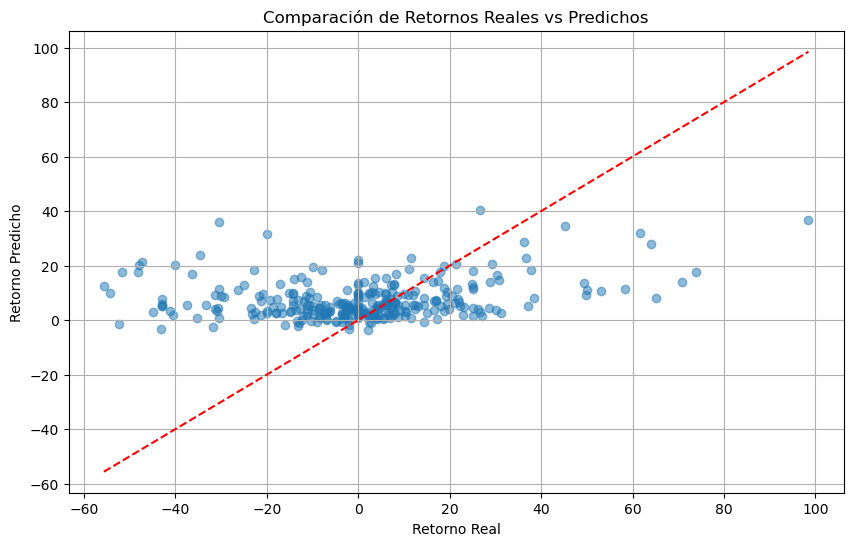

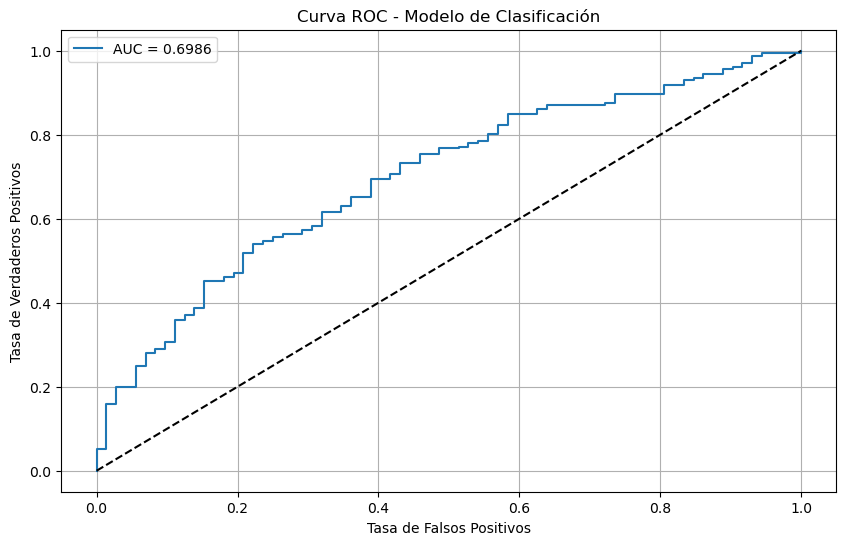

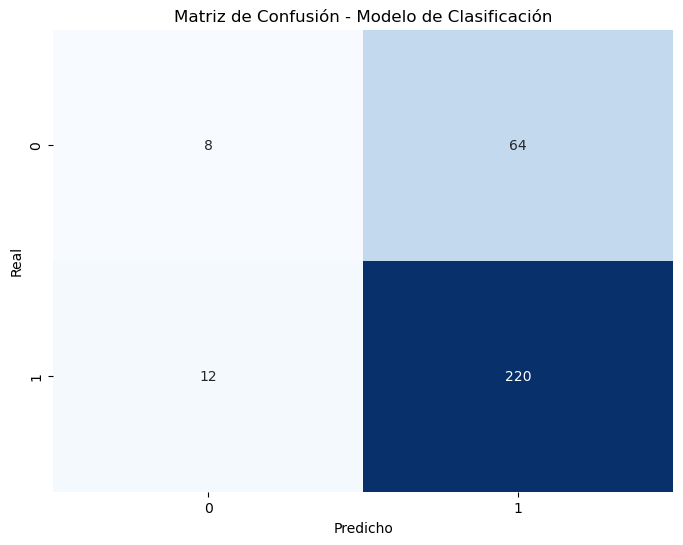

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizar distribución de predicciones vs valores reales (regresión)
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, final_y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--')
plt.xlabel('Retorno Real')
plt.ylabel('Retorno Predicho')
plt.title('Comparación de Retornos Reales vs Predichos')
plt.grid(True)
plt.show()

# Visualizar curva ROC para clasificación
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test_class, final_y_prob_class)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test_class, final_y_prob_class):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Modelo de Clasificación')
plt.legend()
plt.grid(True)
plt.show()

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test_class, final_y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Modelo de Clasificación')
plt.show()